# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `13`

* Miguel Landum, 35019 - Hours worked on the project
* Niklas Schmitz, 62689 - Hours worked on the project
* Pol Parra, 62692 - Hours worked on the project
* Til Dietrich, 62928 - Hours worked on the project




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**


**NOTE to run code locally:** add data (data_d3.pickle, data_d4.pickle) to **assignment-3/data/** folder

## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [83]:
# !pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.3 MB/s eta 0:00:00a 0:00:01


In [238]:
### Your code Here
import pickle
from itertools import islice

data_d3=pickle.load(open("data/data_d3.pickle", "rb"))
data_d4=pickle.load(open("data/data_d4.pickle", "rb"))

first_elements = list(islice(data_d3, 5))
print(first_elements[0])
print(data_d3[first_elements[0]])
print(len(data_d3[first_elements[0]]))
print(len(data_d3[first_elements[1]])) # => elements in dict have different amount of elements in them

A0A024R1R8
{1, 771, 775, 263, 137, 11, 531, 1176, 922, 30, 927, 1185, 673, 675, 423, 296, 1704, 2043, 813, 304, 48, 52, 693, 1080, 1083, 1211, 1085, 1469, 69, 454, 1865, 458, 842, 1609, 1618, 467, 1109, 214, 1237, 473, 90, 603, 1379, 229, 1768, 1513, 1260, 109, 1645, 1007, 112, 1521, 242, 2035, 1652, 1525, 1270, 119, 1017, 123, 508, 1149}
62
178


## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [303]:
### Add supporting functions here
import numpy as np
import time
from scipy.sparse import csr_matrix
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
import pandas as pd

def JaccardSim(d1, d2):
    a =np.inner(d1,d2)
    bc=np.sum(d1+d2)-a
    return a/bc

def convert_to_binary_matrix(data):
    # Extract all unique values to create the universe of elements
    all_values = set()
    for values in data.values():
        all_values.update(values)

    # Create a mapping from values to index
    value_to_index = {value: idx for idx, value in enumerate(all_values)}

    # Number of unique elements
    num_elements = len(all_values)

    # Prepare data for csr_matrix
    rows = []
    cols = []
    data_values = []

    for key, values in data.items():
        for value in values:
            rows.append(key)
            cols.append(value_to_index[value])
            data_values.append(1)  # Presence of the element

    # Convert document IDs to numerical indices
    keys_to_index = {}
    indices_to_key = {}
    for idx, doc in enumerate(data.keys()):
        keys_to_index[doc] = idx
        indices_to_key[idx] = doc
    row_indices = [keys_to_index[doc] for doc in rows]

    # Create and return CSR matrix
    return csr_matrix((data_values, (row_indices, cols)), shape=(len(data), num_elements)), keys_to_index, indices_to_key

def MakeBucketsT(TDocs, perms, N, M, B, R, NB):
    Buckets={}
    all_docs=set(range(N))
    for b in range(B):
        SIGS=np.zeros((N, R), dtype="int32")           # initializes line sig
        for r in range(R):
            perm=perms[b*R+r]
            L=all_docs.copy()                         # gets all docs as a set
            i=0 
            while len(L)>0:
                elem=perm[i]                          # get new element  from permutation
                docs_found=TDocs[elem] & L            # get all the docs with a set bit on that elem that are still on the list
                if len(docs_found)>0:                 # if anything was found
                    SIGS[list(docs_found), r]=i       #   set the line sig to the current position from the perm
                    L=L-docs_found                    #   update the current list removing the found docs
                i+=1                                  # update the current position
                if i==M:                              #this is the case that the document is empty 
                    SIGS[list(L), r]=i                # Highly unlikely in a real data set  
                    L={}
                                                      # we have completed the signature for a given band, 
                                                      # now make the hashes for each document
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    # Convert to Sparse Row matrix format if it's not already
    if not isinstance(Data, csr_matrix):
        Data = csr_matrix(Data)
    # Transpose the data set
    DataT = Data.transpose() # use method transpose() of scipy.csr_matrix
    DataT = [set(DataT.indices[DataT.indptr[i]:DataT.indptr[i + 1]]) for i in range(M)]
    P = B * R # number of permutations
    # Generating permutations
    perms = [np.random.permutation(M) for i in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, M, B, R, NB)
    return buckets

# Function to time LSHT for given B and R
def time_LSHT(data, bands, rows):
    start_time = time.time()
    buckets = LSHT(data, bands, rows)
    end_time = time.time()
    return buckets, end_time - start_time

def print_similar_protein_pairs(buckets):
    for b, buck in buckets:
        if len(buckets[(b,buck)])>1:
            print("Band", b, "suggests these similar docs:", buckets[(b,buck)])

def DrawSimPlot(B, R):
    S=np.arange(0,1.0,.01)
    v=(1/B)**(1/R)
    P=1-(1-S**R)**B
    plt.figure(figsize=(7,5))
    plt.plot(S,P)
    plt.axvline(x = v, linestyle ="--", color ='r')
    plt.title("Candidate pairs probability for B=%d and R=%d" % (B,R))
    plt.xlabel("Document Similarity")
    plt.ylabel("Probability of being a candidate pair")

    plt.grid()
    plt.show()
    
def plot_timing_results(B_values, R_values, timing_results):
    # Plotting
    fig, ax = plt.subplots()
    if len(R_values) == 1:
        for R_val in R_values:
            timing_for_R = [timing_results[(B_val, R_val)] for B_val in B_values]
            ax.plot(B_values, timing_for_R, label=f"R={R_val}")
            ax.set_xlabel("Number of Bands per row (B)")
    else:
        for B_val in B_values:
            timing_for_B = [timing_results[(B_val, R_val)] for R_val in R_values]
            ax.plot(R_values, timing_for_B, label=f"B={B_val}")
            ax.set_xlabel("Number of Rows per Band (R)")

    
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Time Taken for LSHT with Different B and R")
    ax.legend()
    plt.grid(True)
    plt.show()
    
def get_probabilities(s_values, band_values, row_values):
    # Get probabilities
    probabilities = []
    for b_val in band_values:
        for r_val in row_values:
            for s in s_values:
                probability = 1 - (1 - s ** r_val) ** b_val
                probabilities.append([probability, b_val, r_val, s])
                # print("The probability that proteins share at least one band signature if they are %4.2f similar is: %7.4f" % (s, probability))
    return probabilities
        


# Create MinHash signatures from sparse matrix
def create_minhash_from_sparse(matrix, num_perm):
    minhashes = []
    for i in range(matrix.shape[0]):
        minhash = MinHash(num_perm=num_perm)
        # reinitialization of minhash is not a problem as the library ensures that the same hash functions are used as long as num_perm stays the same value
        for idx in matrix[i].indices:
            minhash.update(idx)
        minhashes.append(minhash)
    return minhashes

def init_minhash_lsh(num_perm, threshold):
    return MinHashLSH(threshold=threshold, num_perm=num_perm)


,Probability,Num_band,Num_row,similarity
2,0.999999,20,2,0.7
5,0.995878,20,4,0.7
6,0.075293,20,8,0.5
9,0.000305,20,16,0.5
14,1.000000,40,2,0.7
17,0.999983,40,4,0.7
18,0.144916,40,8,0.5
20,0.906991,40,8,0.7
21,0.000610,40,16,0.5
26,1.000000,80,2,0.7


Final promising parameters


,Probability,Num_band,Num_row,similarity
18,0.144916,40,8,0.5
19,0.492142,40,8,0.6
20,0.906991,40,8,0.7
30,0.268832,80,8,0.5
31,0.742080,80,8,0.6
32,0.991349,80,8,0.7


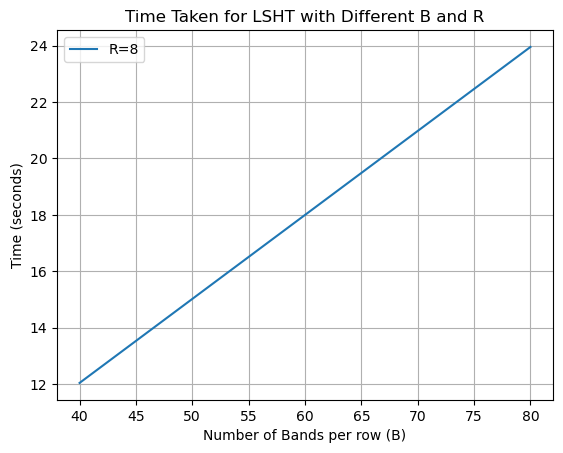

In [306]:
import random

csr_data, keys_to_index, indices_to_key = convert_to_binary_matrix(data_d3)

# Test different values of B and R
bands_values = [20, 40, 80, 120]  # Adjust the values as needed
rows_values = [2, 4, 8, 16]  # Adjust the values as needed

s_values = [0.5, 0.6, 0.7]
probs = get_probabilities(s_values, bands_values, rows_values)

probs_df = pd.DataFrame(probs, columns=["Probability", "Num_band", "Num_row", "similarity"])

promissing_params = probs_df[((probs_df["Probability"] < 0.3) & (probs_df["similarity"] == 0.5)) | ((probs_df["Probability"] > 0.85) & (probs_df["similarity"] == 0.7))]
display(promissing_params)
# => promising results to evaluate further: Bands = [40, 80], Rows = [8]
promissing_params = probs_df[((probs_df["Num_band"] == 40) & (probs_df["Num_row"] == 8)) | ((probs_df["Num_band"] == 80) & (probs_df["Num_row"] == 8))]
print("Final promising parameters")
display(promissing_params)

# Collect timing results of the most promissing parameters
bands_values = [40, 80]  # Adjust the values as needed
rows_values = [8]  # Adjust the values as needed

buckets_results = {}
timing_results = {}
for b_val in bands_values:
    for r_val in rows_values:
        specific_buckets, specific_time_results = time_LSHT(csr_data, b_val, r_val)
        buckets_results[(b_val, r_val)] = specific_buckets
        timing_results[(b_val, r_val)] = specific_time_results

plot_timing_results(bands_values, rows_values, timing_results)



# print_similar_protein_pairs(buckets)

In [318]:
import random
import math

test_bucket = buckets_results[(40,8)]
len_bucket = len(test_bucket)

sample_size = math.floor(len_bucket / 10)
random_keys = random.sample(list(test_bucket.keys()), sample_size)

# Create a new dictionary with the sampled keys
sampled_dict = {key: test_bucket[key] for key in random_keys}

In [319]:
len(sampled_dict)

7595

In [310]:
type(buckets_results[(40,8)])

dict

In [237]:
from itertools import combinations
counter = 0
for b, buck in buckets:
    # print(counter)
    counter += 1
    if len(list(buckets[(b,buck)])) < 1000:
        combs = combinations(buckets[(b,buck)], 2)
        for i, j in combs:
            document_i = indices_to_key[i]
            document_j = indices_to_key[j]
            true_sim = JaccardSim(csr_data.getrow(i).toarray()[0], csr_data.getrow(j).toarray()[0])
            if true_sim > 0.5:
                print("Documents %s and %s are in truth %7.4f similar"  % (document_i , document_j, true_sim))
        else:
            continue
        break

Documents O60242 and O15040 are in truth  0.5013 similar
Documents O14594 and O14976 are in truth  0.5257 similar
Documents O14594 and O15047 are in truth  0.5050 similar
Documents O75173 and O00468 are in truth  0.5082 similar
Documents O00468 and O15040 are in truth  0.5260 similar
Documents O00468 and O75037 are in truth  0.5158 similar
Documents A0A0C4DH34 and A0A075B6R2 are in truth  0.6352 similar
Documents O60242 and O15040 are in truth  0.5013 similar
Documents O75037 and O43150 are in truth  0.5114 similar
Documents A2PYH4 and O14976 are in truth  0.5233 similar
Documents O60242 and O15040 are in truth  0.5013 similar
Documents O00555 and O75153 are in truth  0.5444 similar
Documents A0A0B4J2D9 and A0A0C4DH73 are in truth  0.7333 similar
Documents A0A0C4DH34 and A0A075B6R2 are in truth  0.6352 similar
Documents O00267 and O15047 are in truth  0.5054 similar
Documents A0A0C4DH34 and A0A075B6R2 are in truth  0.6352 similar
Documents O60437 and O75037 are in truth  0.5195 similar

In [32]:
bands = 
rows = 

# Number of permutations
# is product of bands and rows
num_perm = bands * rows

# Generate MinHash signatures from sparse matrix
minhashes = create_minhash_from_sparse(csr_data, num_perm)

# Define threshold
threshold = 0.6
lsh = init_minhash_lsh(num_perm, threshold)

# Populate lsh with calculated MinHash signatures
for doc, minhash in zip(data_d3.keys(), minhashes):
    lsh.insert(doc, minhash)
    
print("\nLSH index created and signatures inserted.")

# Example Query: Find similar items to specific item key: P28223 => Bonus question
query_key = "P28223" # Code to answer the bonus question
query_index = keys_to_index[query_key]
results = lsh.query(minhashes[query_index])
print(f"Items similar to {query_key}: {results}")
len(results)

# delete variables from memory so rest of code doesn't get affected
del minhashes
del lsh


LSH index created and signatures inserted.
Items similar to P28223: ['P18031', 'O15079', 'Q6UX04', 'P51665', 'O95573', 'P49915', 'Q96CU9', 'Q8N1K5', 'Q9Y6F8', 'Q9UPZ6', 'Q9Y6K8', 'O95751', 'Q14696', 'Q5TDP6', 'P33261', 'Q9NX45', 'Q99717', 'O14657', 'P33908', 'Q6XUX3', 'O75635', 'Q96M98', 'Q9UNQ0', 'Q8N0W7', 'Q8N8Y2', 'O60841', 'P08237', 'Q15583', 'Q5TID7', 'P36894', 'Q502W6', 'Q12882', 'Q5JW98', 'Q9H900', 'Q13127', 'P28062', 'O60476', 'Q8NBH2', 'Q9BYV9', 'O00505', 'Q9UGM3', 'Q9H270', 'Q8N344', 'Q96EA4', 'Q96SI9', 'Q96A65', 'O60879', 'Q9UKT6', 'Q9H2D6', 'O60861', 'Q6ZNW5', 'Q92541', 'P86790', 'Q9Y376', 'O14513', 'Q14012', 'Q6UX82', 'O14777', 'Q9Y6L6', 'P14672', 'Q86VB7', 'Q9UNK0', 'O60383', 'P55160', 'Q5VW32', 'P27352', 'Q9UHC1', 'P13861', 'P50443', 'Q15052', 'Q8IYM9', 'O60890', 'Q14CB8', 'P55084', 'Q8IUH3', 'Q8NGE2', 'P27635', 'P51946', 'P29353', 'O75503', 'P52888', 'Q8NFR9', 'P50570', 'P31274', 'Q10713', 'Q8N807', 'O43566', 'P28472', 'Q13507', 'Q13563', 'Q8IUX4', 'P0DOX4', 'Q9NRY4', 

In [13]:
# TODO adjust parameters bands and rows so the LSHT is able to capture the most similar protein pairs.
# Implement a method to evaluate the different settings
# Otherwise task 1 is done

### Your short analysis here

Plan:
- use sparse matrices!
- use MinHashing to calculate the Jaccard Similarity as it is a good approach for large datasets (like d4)
- use LSHT instead of LSH as it heavily outperformes LSH for sparse matrices (which is the case for this data)


## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [ ]:
### Add supporting functions here



In [ ]:
### Add processing code here



## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
